# Train a model
In the previous notebook, we processed some Raven annotation files so that we could use audio that has been annotated by expert annotators, as training data for a classifer. In this notebook, we will train that classifier

In [1]:
## Opensoundscape imports
from opensoundscape.annotations import BoxedAnnotations
from opensoundscape.torch.models.cnn import CNN

# general purpose packages
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch 
import random 

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# read in the training and test sets produced from annotated audio, using the previous notebook
training_set = pd.read_csv("training_set.csv", index_col=[0,1,2])
test_set = pd.read_csv("test_set.csv", index_col=[0,1,2])

In [3]:
# Filter just to our species of interest
species_of_interest = ["NOCA", "EATO", "SCTA", "BAWW", "BCCH", "AMCR", "NOFL"]
training_set = training_set[species_of_interest]
test_set = test_set[species_of_interest]

In [4]:
# Split our training data into training and validation sets
train_df, valid_df = train_test_split(training_set, test_size=0.1, random_state=0)

In [5]:
## Roughly balance the training set ##
# this upsamples the less common classes and improves performance
# in classes that would otherwise be rare in the training set
positives_dfs = pd.concat([train_df[train_df[species] ==1].sample(800, replace=True, random_state=0) for species in train_df.columns])
negatives = train_df[train_df.sum(axis=1) == 0].sample(2000, replace=True)
balanced_train_df = pd.concat([positives_dfs, negatives])

Now we will train the classifier. We're using a resnet34 architecture CNN.

In [6]:
%%capture --no-stdout --no-display

model = CNN('resnet34',classes=train_df.columns,sample_duration=3.0, single_target=False)
model.train(balanced_train_df, valid_df, epochs = 30, batch_size= 64, log_interval=100, num_workers = 32)


Training Epoch 0
Epoch: 0 [batch 0/119, 0.00%] 
	DistLoss: 0.732
Metrics:
Epoch: 0 [batch 100/119, 84.03%] 
	DistLoss: 0.426
Metrics:
Metrics:
	MAP: 0.472

Validation.
Metrics:
	MAP: 0.655

Training Epoch 1
Epoch: 1 [batch 0/119, 0.00%] 
	DistLoss: 0.270
Metrics:
Epoch: 1 [batch 100/119, 84.03%] 
	DistLoss: 0.270
Metrics:
Metrics:
	MAP: 0.770

Validation.
Metrics:
	MAP: 0.714

Training Epoch 2
Epoch: 2 [batch 0/119, 0.00%] 
	DistLoss: 0.221
Metrics:
Epoch: 2 [batch 100/119, 84.03%] 
	DistLoss: 0.206
Metrics:
Metrics:
	MAP: 0.861

Validation.
Metrics:
	MAP: 0.783

Training Epoch 3
Epoch: 3 [batch 0/119, 0.00%] 
	DistLoss: 0.181
Metrics:
Epoch: 3 [batch 100/119, 84.03%] 
	DistLoss: 0.167
Metrics:
Metrics:
	MAP: 0.906

Validation.
Metrics:
	MAP: 0.802

Training Epoch 4
Epoch: 4 [batch 0/119, 0.00%] 
	DistLoss: 0.109
Metrics:
Epoch: 4 [batch 100/119, 84.03%] 
	DistLoss: 0.142
Metrics:
Metrics:
	MAP: 0.930

Validation.
Metrics:
	MAP: 0.813

Training Epoch 5
Epoch: 5 [batch 0/119, 0.00%] 
	

## Use the model to predict on the test set

In [7]:
predictions = model.predict(test_set)

## Plot the histograms for score distributions
We can validate the model's perfomance by plotting histograms of the scores outputted by the model on our test set. If a classifier performs well, it will give high scores to the positives (audio clips containing the species of interest) and lower scores to the negatives (audio clips that do not contain the species of interest). This classifier works well for some species, and has failed to learn others., it could be used to save a lot of listening effort if used for 'top-down listening' to confirm presence at a site. Top-down listening is a process where audio clips are listened to by experts to verify presence at a start, starting with the highest scoring files and listening 'down' to lower scoring clips if necessary.

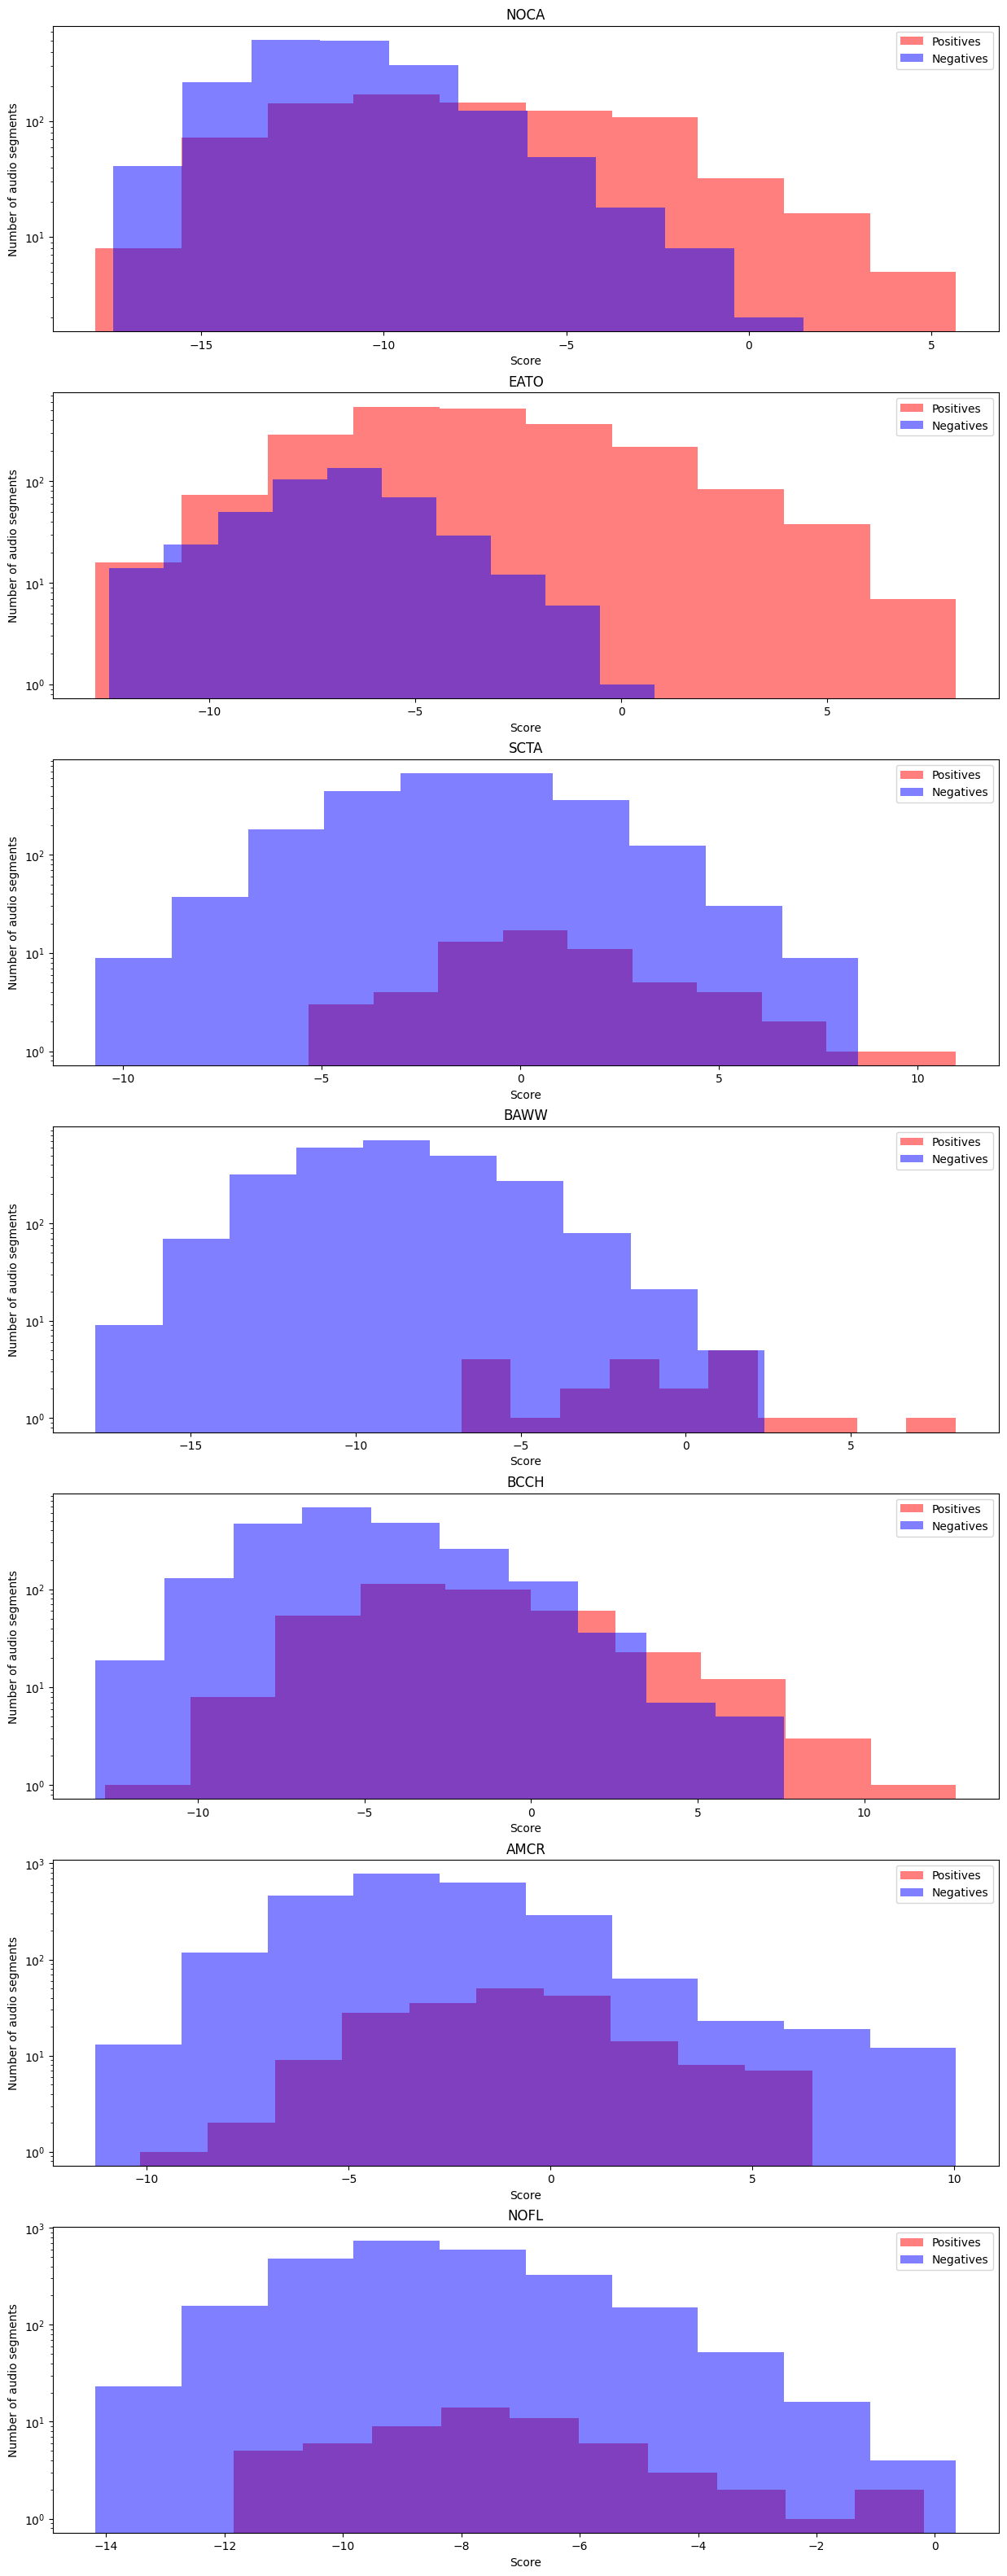

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(7,1, figsize = (15,40))
axs = np.ravel(axs)
for ax, species in enumerate(model.classes):
    positives = test_set[species] == 1
    negatives = test_set[species] == 0
    axs[ax].hist(predictions.loc[positives][species], alpha=0.5, color="red", label="Positives")
    axs[ax].hist(predictions.loc[negatives][species], alpha=0.5, color="blue", label="Negatives")
    axs[ax].set_yscale("log")
    axs[ax].title.set_text(species)
    axs[ax].set_ylabel("Number of audio segments")
    axs[ax].set_xlabel("Score")
    axs[ax].legend()

## Top Down listening 
This is a demonstration of how the model could be used for 'top-down listening', to greatly reduce the listening time needed to determine the presence of a species at a site.

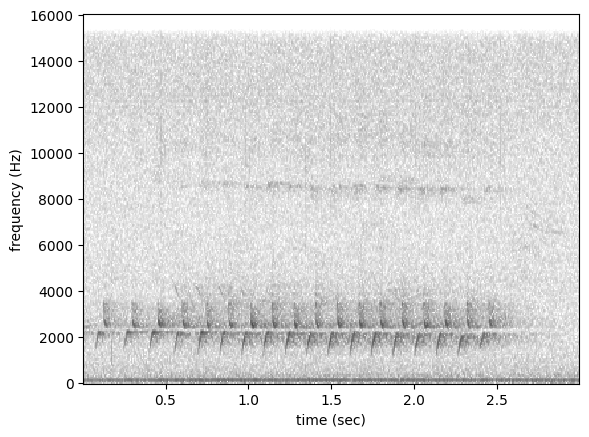

In [ ]:
from opensoundscape import Audio
from opensoundscape import Spectrogram
import IPython.display as ipd
for species in model.classes:
    topscore = predictions[species].sort_values(ascending=False).index[0]
    audio = Audio.from_file(topscore[0], 
                            offset = topscore[1], 
                            duration = topscore[2]-topscore[1])
    ipd.display(ipd.Audio(audio.samples, rate=audio.sample_rate, autoplay=True), clear=True)
    Spectrogram.from_audio(audio).plot()
    input(f"This is the highest scoring audio segment for {species}. Does it contain {species}?")